The goal of this file is to get you familiar with how dataset is constructed.

It consists of:
 1. Rendered images of our object
 2. Projection matrix of object in our 3D space
 3. Global model view and projection matrices which depends on our camera (it's intrinsic and extrinsic parameters)

Camera in 3D world is placed at (0, 0, -1) position, looking perpendicular at XY plane, and have 35 mm of focal length.

In [67]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from json import load

from utils import project_points
plt.rcParams["figure.figsize"] = (10, 10)

Camera info file is global for all dataset so it stored in separate file

It containse two important matricies for you to be able to project 3D points on 2d image

In [68]:
camera_info = load(open("./reference/camera_info.json"))

model_view_matrix = np.array(camera_info['model_view_matrix'])
projection_matrix = np.array(camera_info['projection_matrix'])

Boubding box poins is obviously the edges of our box that holds our model in 3d world space coordinate system

In [69]:
bounding_box_points_in_3d = np.float32(
    [(-0.156, -0.182, -0.032), 
     ( 0.156, -0.182, -0.032),
     (-0.156,  0.163, -0.032),
     ( 0.156,  0.163, -0.032),
     (-0.156, -0.182,  0.034),
     ( 0.156, -0.182,  0.034),
     (-0.156,  0.163,  0.034),
     ( 0.156,  0.163,  0.034)])

homogenious_bb_points = np.c_[bounding_box_points_in_3d, np.ones((8,1), dtype=np.float32)]

Here I createt smaler version of dataset where our model is represented only in two postions:
1. From above
2. Side view

In [70]:
above_image = cv2.cvtColor(cv2.imread('./reference/0.jpg'), cv2.COLOR_BGR2RGB)
above_matrix = np.array(load(open("./reference/0_mat.json")))

In [71]:
side_image = cv2.cvtColor(cv2.imread('./reference/1.jpg'), cv2.COLOR_BGR2RGB)
side_matrix = np.array(load(open("./reference/1_mat.json")))

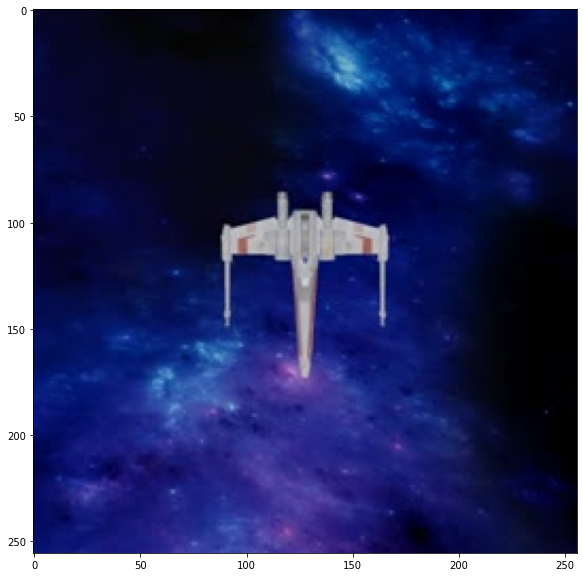

In [72]:
plt.imshow(above_image)

On above image model is placed at the origin and it dosen have any rotation so it's matrix is obviously boring

In [73]:
above_matrix

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

If we project axis on image you will get better anderstanding of placement in 3D world

Notice that Z axis is looking directly in camera and representet with a dot

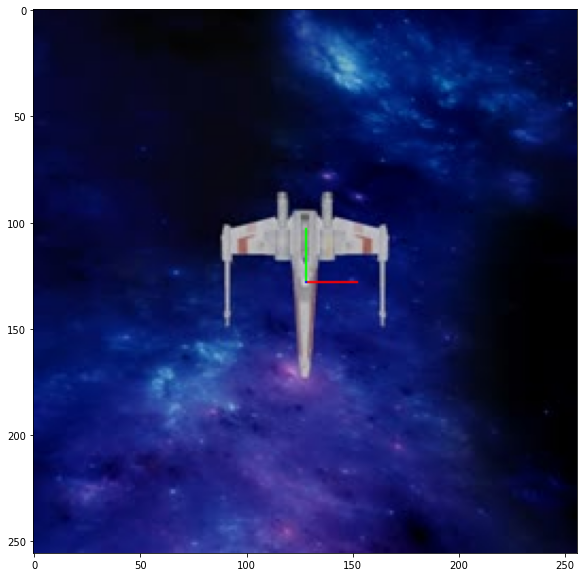

In [75]:
axis_points_3d = np.float32([[0.1, 0, 0, 1], [0, 0.1, 0, 1], [0, 0, 0.1, 1], [0, 0, 0, 1]])

projected_axis = project_points(above_image, axis_points_3d, model_view_matrix, projection_matrix, above_matrix)

xa, ya, za, center = np.array(projected_axis).astype(int)
img = above_image.copy()

img = cv2.line(img, center, xa, (255,0,0), 1)
img = cv2.line(img, center, ya, (0,255,0), 1)
img = cv2.line(img, center, za, (0,0,255), 1)

plt.imshow(img)

If we now project our bounding point you'll see how they look from camera perspective

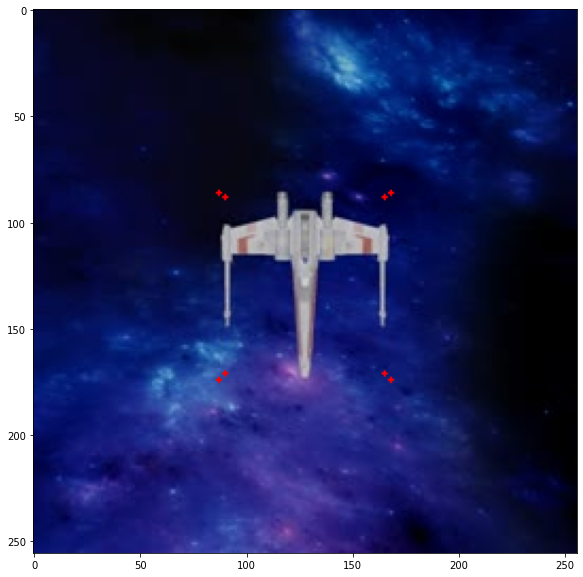

In [78]:
img = above_image.copy()
projected_bb = np.array(project_points(img, 
                                       homogenious_bb_points, 
                                       model_view_matrix, 
                                       projection_matrix, 
                                       above_matrix)).astype(int)

for pbb in projected_bb:
    img = cv2.circle(img, pbb, 1, (255,0,0), -1)

plt.imshow(img)

Now lets look how all of that will look if we turn our model

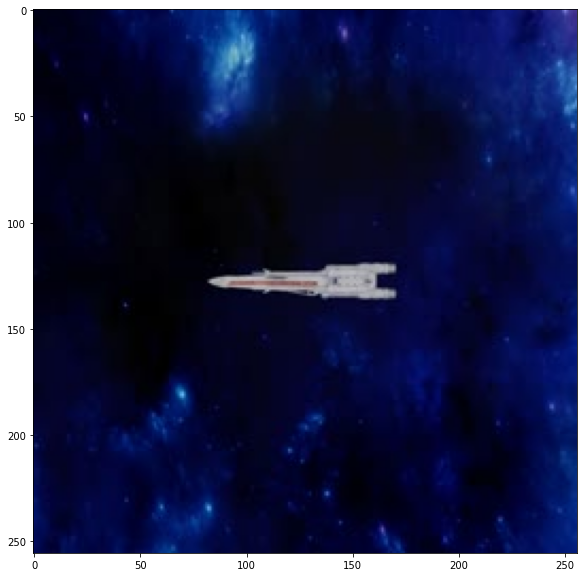

In [79]:
plt.imshow(side_image)

Axis will look the same because camera didn't move 

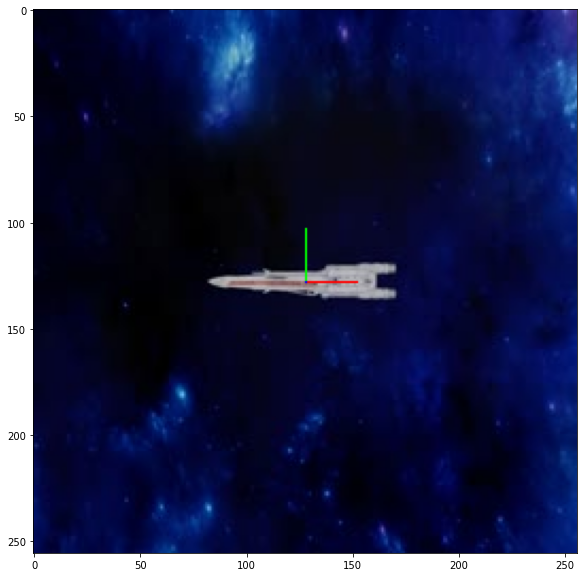

In [81]:
axis_points_3d = np.float32([[0.1, 0, 0, 1], [0, 0.1, 0, 1], [0, 0, 0.1, 1], [0, 0, 0, 1]])

projected_axis = project_points(side_image, axis_points_3d, model_view_matrix, projection_matrix, above_matrix)

xa, ya, za, center = np.array(projected_axis).astype(int)
img = side_image.copy()

img = cv2.line(img, center, xa, (255,0,0), 1)
img = cv2.line(img, center, ya, (0,255,0), 1)
img = cv2.line(img, center, za, (0,0,255), 1)

plt.imshow(img)

But if you look at bounding points from when ship is rotated to its side they projection will look different

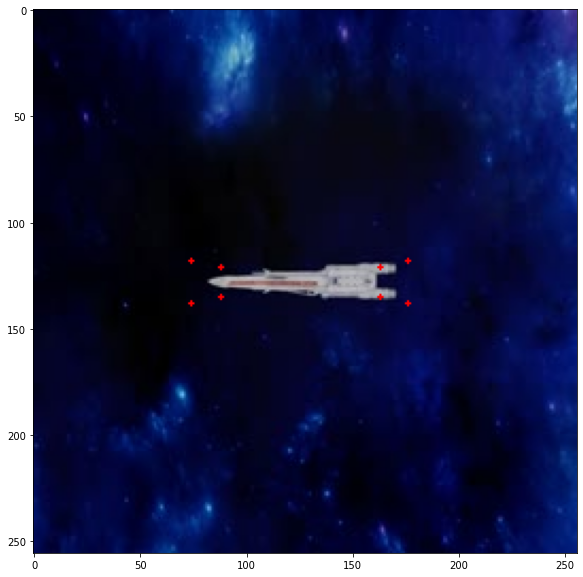

In [66]:
img = side_image.copy()
projected_bb = np.array(project_points(img, 
                                       homogenious_bb_points, 
                                       model_view_matrix, 
                                       projection_matrix, 
                                       side_matrix)).astype(int)

for pbb in projected_bb:
    img = cv2.circle(img, pbb, 1, (255,0,0), -1)

plt.imshow(img)

Projection is different because transformation matrix for rotated object is not the same as for object on above image

In [82]:
side_matrix

array([[-4.37113883e-08,  1.00000000e+00, -4.37113883e-08,
         0.00000000e+00],
       [-0.00000000e+00, -4.37113883e-08, -1.00000000e+00,
         0.00000000e+00],
       [-1.00000000e+00, -4.37113883e-08,  1.91068568e-15,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

Let's now go to our goal and draw some shooting lasers

In [83]:
lasers = np.float32((
    ((-0.145, -0.1, -0.01), (-0.145, -0.3, -0.01)),
    ((-0.145, -0.1,  0.01), (-0.145, -0.3,  0.01)),
    (( 0.145, -0.1, -0.01), ( 0.145, -0.3, -0.01)),
    (( 0.145, -0.1,  0.01), ( 0.145, -0.3,  0.01))
))

In [88]:
np.c_[lasers[0], np.ones((2,1), dtype=np.float32)]

array([[-0.145, -0.1  , -0.01 ,  1.   ],
       [-0.145, -0.3  , -0.01 ,  1.   ]], dtype=float32)

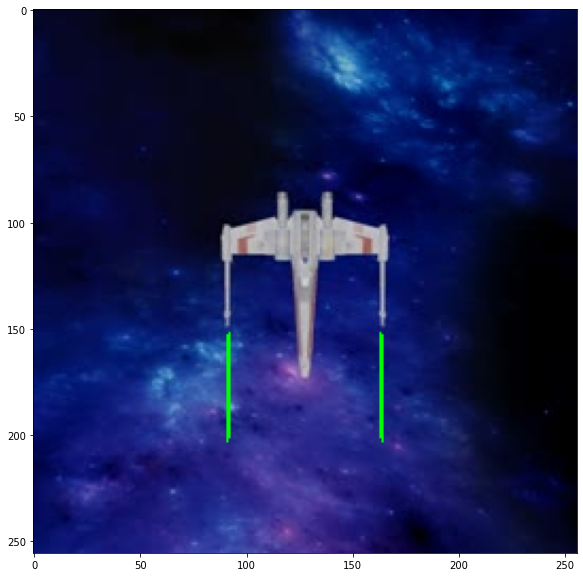

In [94]:
img = above_image.copy()
for lpts in lasers:
    h_lpts = np.c_[lpts, np.ones((2,1), dtype=np.float32)]
    points = project_points(img, h_lpts, model_view_matrix, projection_matrix, above_matrix)
    p1, p2 = np.array(points).astype(int)
    img = cv2.line(img, p1, p2, (0,255,0), 1)

plt.imshow(img)

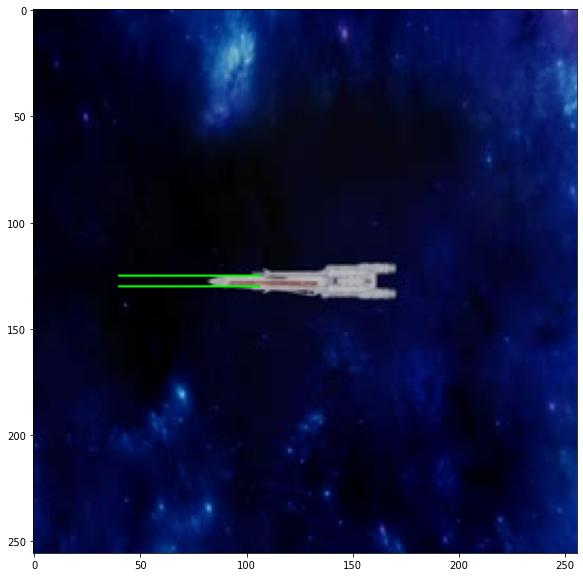

In [95]:
img = side_image.copy()
for lpts in lasers:
    h_lpts = np.c_[lpts, np.ones((2,1), dtype=np.float32)]
    points = project_points(img, h_lpts, model_view_matrix, projection_matrix, side_matrix)
    p1, p2 = np.array(points).astype(int)
    img = cv2.line(img, p1, p2, (0,255,0), 1)

plt.imshow(img)

And for final lets get some image from our dataset

In [96]:
ds_image = cv2.cvtColor(cv2.imread('./dataset/0.jpg'), cv2.COLOR_BGR2RGB)
ds_matrix = np.array(load(open("./dataset/0_mat.json")))

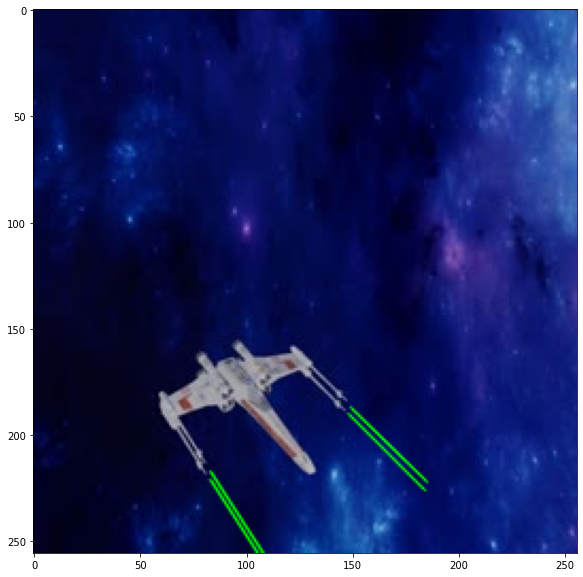

In [98]:
img = ds_image.copy()
for lpts in lasers:
    h_lpts = np.c_[lpts, np.ones((2,1), dtype=np.float32)]
    points = project_points(img, h_lpts, model_view_matrix, projection_matrix, ds_matrix)
    p1, p2 = np.array(points).astype(int)
    img = cv2.line(img, p1, p2, (0,255,0), 1, cv2.LINE_AA)

plt.imshow(img)

Pew Pew, is't this cool as hell?